# Visualizing Attention
### Chapter 7 Module 2

## Importing Libraries
We begin by importing the necessary libraries for loading a pretrained Vision Transformer, processing images, and using FiftyOne to manage and visualize datasets and attention maps.

In [2]:
from transformers import ViTModel, AutoImageProcessor
from PIL import Image
import fiftyone as fo 
import fiftyone.zoo as foz
import torch

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading an ImageNet Sample Dataset
We load a small subset of ImageNet via FiftyOne’s dataset zoo. This gives us real-world image samples to test and visualize attention.

Overwriting existing directory '/Users/dangural/fiftyone/imagenet-sample'
 100% |████|  762.4Mb/762.4Mb [3.0s elapsed, 0s remaining, 282.5Mb/s]      
Extracting dataset...
Parsing dataset metadata
Found 1000 samples
Dataset info written to '/Users/dangural/fiftyone/imagenet-sample/info.json'
Loading 'imagenet-sample'
 100% |███████████████████| 50/50 [21.4ms elapsed, 0s remaining, 2.3K samples/s]      
Dataset 'Imagenet-Sample' created
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



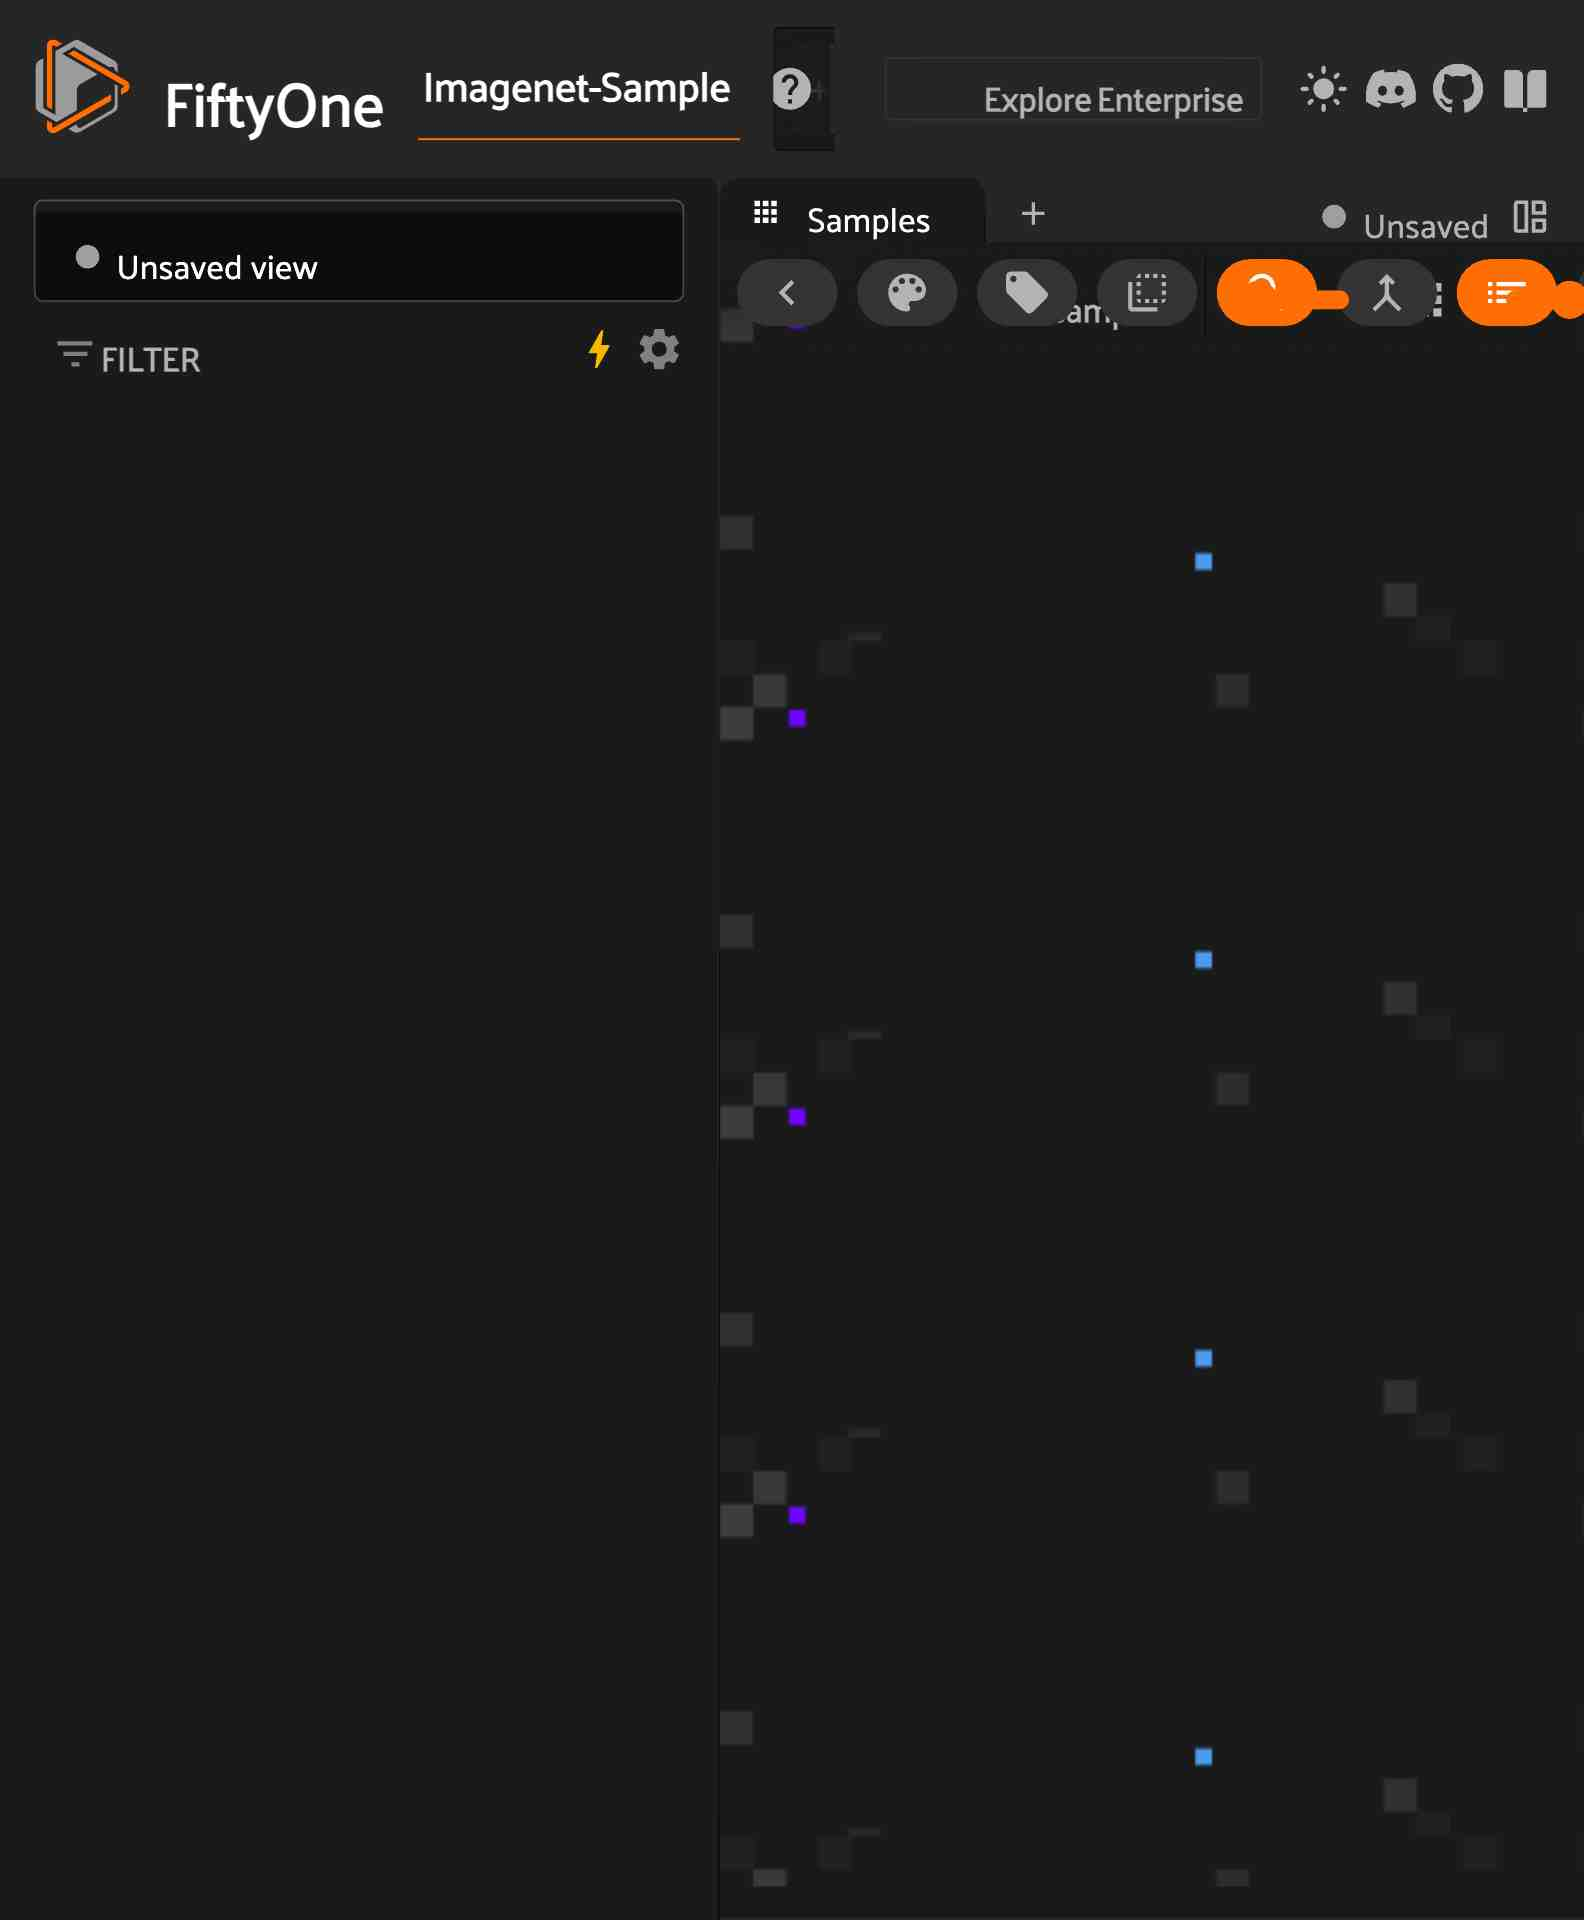

In [3]:
fo.delete_dataset("Imagenet-Sample")
dataset = foz.load_zoo_dataset(
    "imagenet-sample",
    dataset_name="Imagenet-Sample",
    max_samples=50,
    shuffle=True,
    overwrite=True,
)
session = fo.launch_app(dataset)

## Loading the Vision Transformer Model
We load a pretrained ViT model from Hugging Face with output_attentions=True to retrieve attention weights from each layer. The corresponding image processor is also initialized.

In [4]:
model_name = "google/vit-base-patch16-224"
model = ViTModel.from_pretrained(model_name, output_attentions=True)
processor = AutoImageProcessor.from_pretrained(model_name)
model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

## Preprocessing a Single Image
Here we select the first image in the dataset and convert it into the appropriate input tensor using the Hugging Face image processor.

In [5]:
image = Image.open(dataset.first().filepath)
inputs = processor(images=image, return_tensors="pt")

## Performing Inference and Extracting Attention
We pass the image through the model and collect the attention weights from all transformer layers. These attention maps will be used for visualization.

In [6]:
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # list of (B, heads, tokens, tokens)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


## Selecting and Averaging the Last Layer's CLS Attention
We extract the last layer's attention for the [CLS] token across all heads and average them to get a single attention map highlighting where the model focused when forming the global representation.

In [7]:
# Use last layer attention
last_attn = attentions[-1]  # shape: (1, num_heads, tokens, tokens)
cls_attn = last_attn[0, :, 0, 1:]  # shape: (num_heads, num_patches)
cls_attn = cls_attn.mean(0)  # mean over heads

## Reshaping the Attention Map
This reshapes the attention vector into a 2D grid corresponding to the 14x14 patch layout of a 224×224 image split into 16×16 patches.

In [8]:
# For vit-base-patch16-224 → 224/16 = 14 → 14x14 patches
cls_attn_map = cls_attn.reshape(14, 14)

## Upsampling the Attention Map to Image Size
The 14×14 attention map is upsampled to 224×224 using bilinear interpolation to match the original image size, making it suitable for visualization.

In [9]:
import torch.nn.functional as F

# Upsample to image size
attn_map_resized = F.interpolate(
    cls_attn_map.unsqueeze(0).unsqueeze(0),  # (1,1,H,W)
    size=(224, 224),
    mode="bilinear"
).squeeze().numpy()

attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())

In [11]:
attn_map_resized.shape

(224, 224)

## Importing Additional Visualization Libraries
Here we import OpenCV, NumPy, and Matplotlib to support reading, manipulating, and displaying attention maps as heatmaps.

In [17]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Create the folder if it doesn't exist
os.makedirs("attn_maps", exist_ok=True)

# Normalize the attention map to 0-255 and save as a single-channel (grayscale) PNG
attn_map_resized_uint8 = (attn_map_resized * 255).astype(np.uint8)
cv2.imwrite(f"attn_maps/{dataset.first().id}.png", attn_map_resized_uint8)

True

## Saving and Displaying the Attention Map
The attention heatmap is saved to disk and added to the FiftyOne sample view, allowing interactive exploration inside the FiftyOne App.


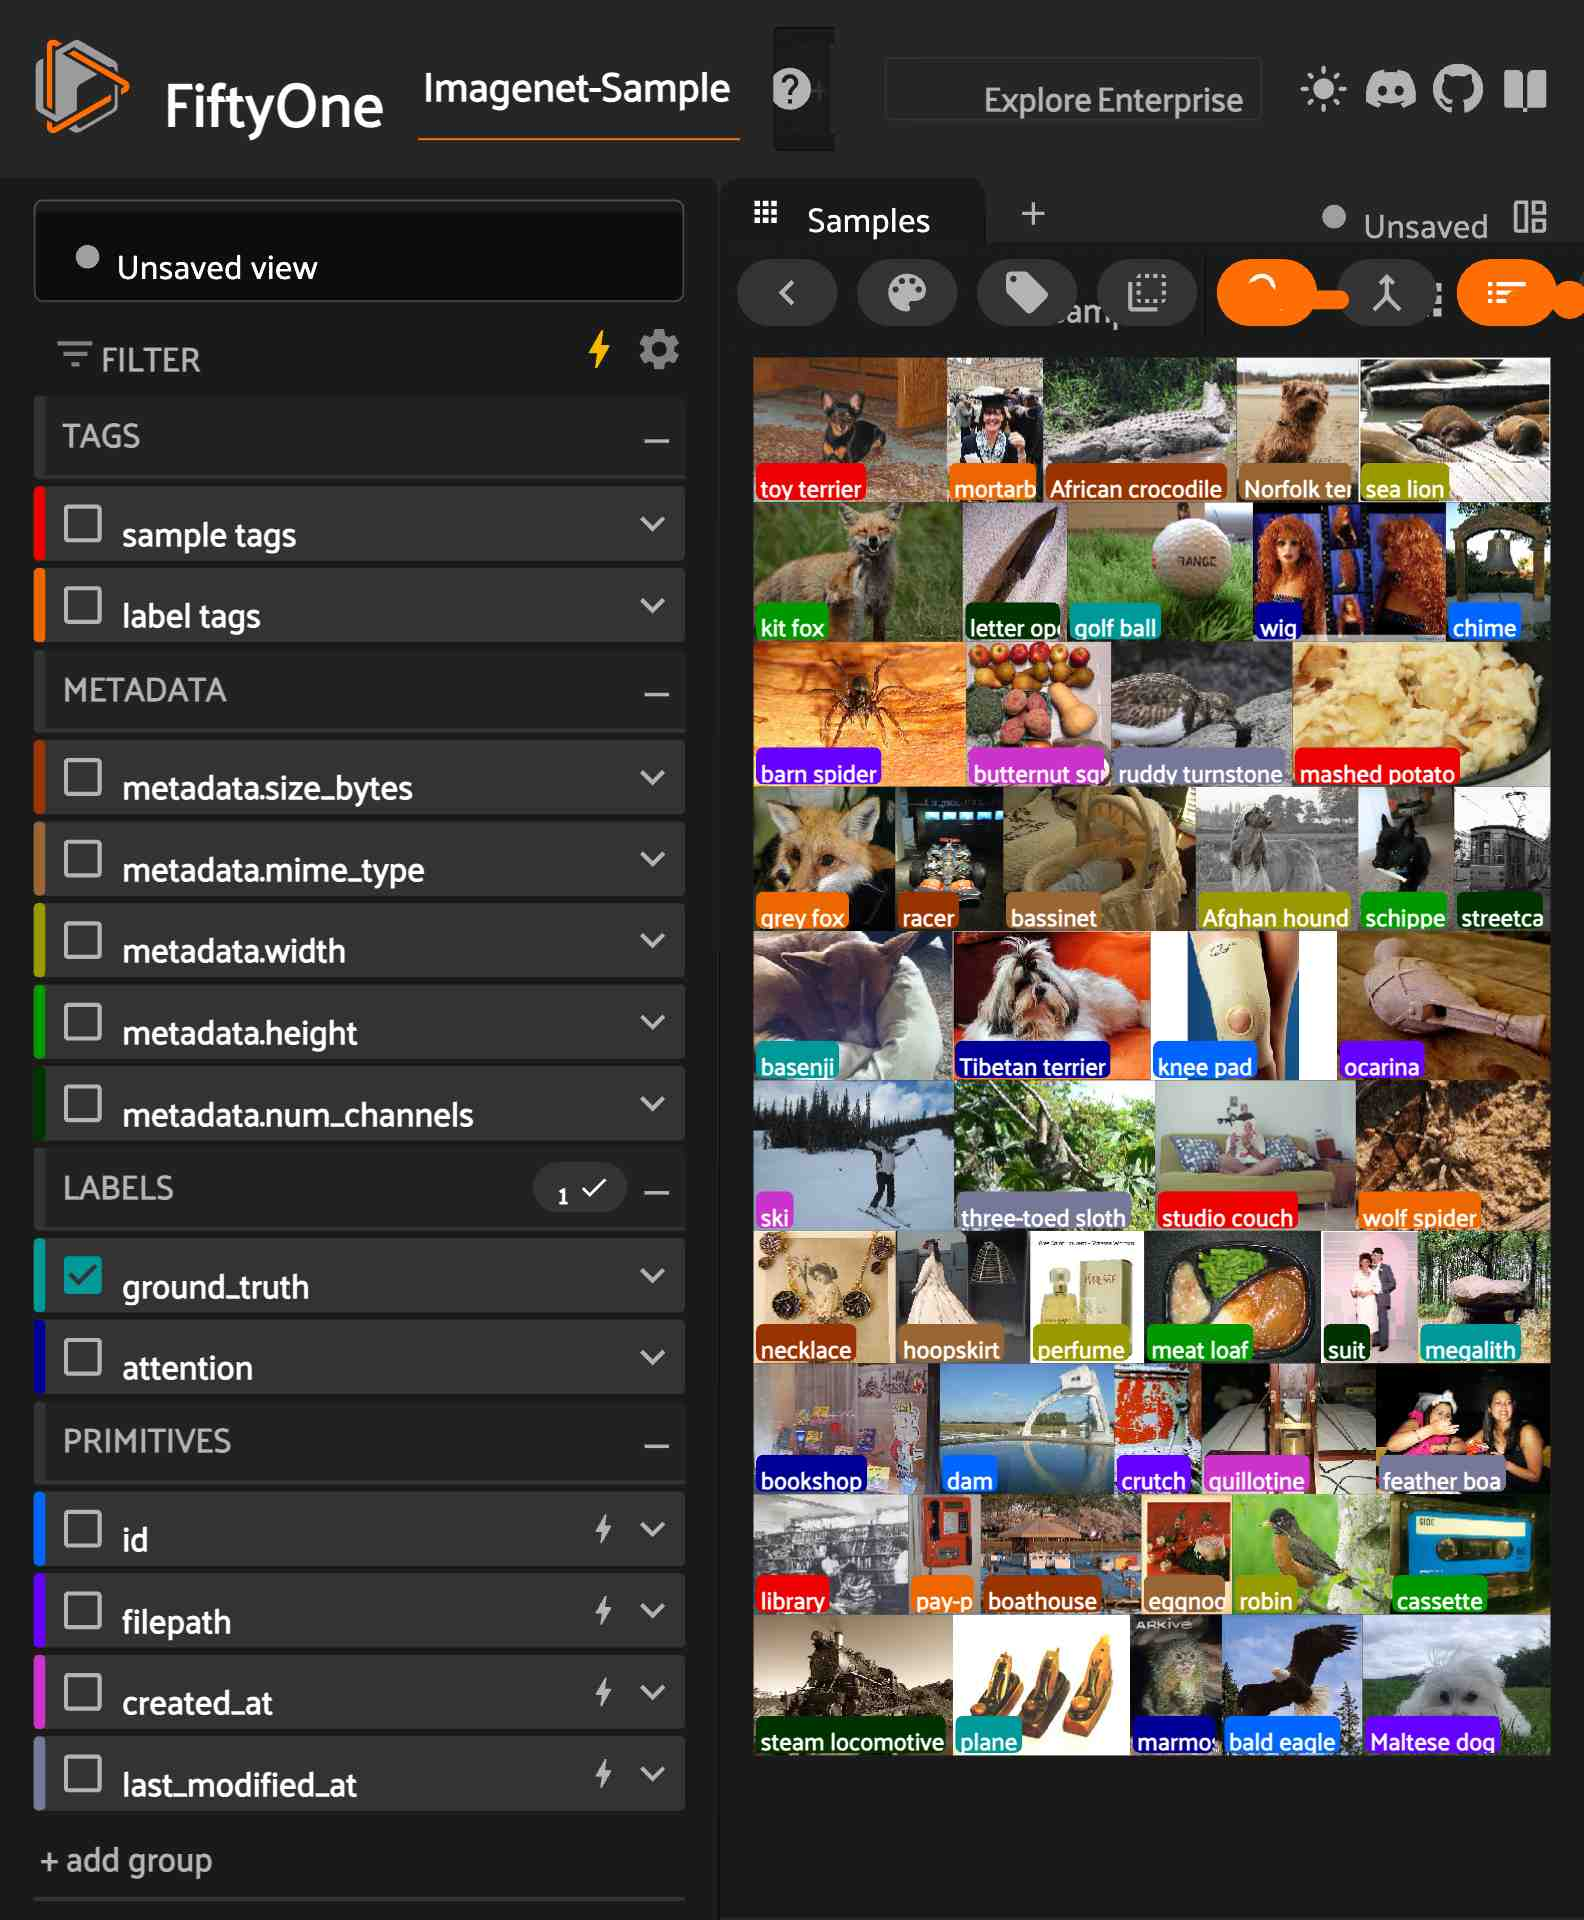

In [20]:
sample = dataset.first()
sample["attention"] = fo.Heatmap(map_path=f"/Users/dangural/Documents/linkedin/tcv/ch7/attn_maps/{dataset.first().id}.png")
sample.save()
session.show()

## Defining Attention Rollout
This function implements attention rollout, a technique that accumulates attention across layers to show how attention flows from input patches to the [CLS] token.

In [24]:
def compute_rollout(attentions, add_residual=True, res_weight=0.1):
    """
    Compute attention rollout from a list of attention matrices.
    - attentions: list of tensors, each of shape (batch, heads, tokens, tokens)
    - returns: rollout attention for [CLS] token
    """
    num_tokens = attentions[0].size(-1)
    rollout = torch.eye(num_tokens).to(attentions[0].device)

    for attn in attentions:
        avg_attn = attn[0].mean(0)  # average over heads
        
        if add_residual:
            avg_attn = res_weight * torch.eye(num_tokens).to(attn.device) + (1 - res_weight) * avg_attn

        avg_attn = avg_attn / avg_attn.sum(dim=-1, keepdim=True)  # normalize
        rollout = avg_attn @ rollout

    return rollout

## Generating Rollout Attention Maps
This applies the attention rollout method and reshapes the resulting map into a 14×14 grid for visualization, just like with the last-layer attention map.

In [25]:
rollout_attn = compute_rollout(attentions)
cls_to_patch = rollout_attn[0, 1:]  # (excluding CLS itself)
cls_map = cls_to_patch.reshape(14, 14)  # for 224x224 input with patch size 16

### Upsampling Rollout Map
Similar to earlier, we upsample the rollout attention to 224×224 pixels for better overlay on the input image.

In [31]:
# Upsample to image size
attn_map_resized = F.interpolate(
    cls_map.unsqueeze(0).unsqueeze(0),  # (1,1,H,W)
    size=(224, 224),
    mode="bilinear"
).squeeze().numpy()

attn_map_resized = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())

# Create the folder if it doesn't exist
os.makedirs("attn_maps", exist_ok=True)

# Normalize the attention map to 0-255 and save as a single-channel (grayscale) PNG
attn_map_resized_uint8 = (attn_map_resized * 255).astype(np.uint8)
cv2.imwrite(f"attn_maps/{dataset.first().id}_rollout.png", attn_map_resized_uint8)

True

## Visualizing Rollout Attention in FiftyOne
The rollout attention map is saved and attached to the sample in FiftyOne, allowing side-by-side comparison with the last-layer attention visualization

In [ ]:
sample = dataset.first()
sample["rollout_attention"] = fo.Heatmap(map_path=f"/Users/dangural/Documents/linkedin/tcv/ch7/attn_maps/{dataset.first().id}_rollout.png")
sample.save()
session.show()